# Numerical Precision

In this section, you will investigate how different convolution
and matrix-matrix multiplication kernel performs when changing the
numerical precision.

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
fatal: destination path 'a4-MaximClouser' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a4-MaximClouser
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 9), reused 7 (delta 3), pack-reused 0
Unpacking objects: 100% (20/20), 257.55 KiB | 278.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a4-MaximClouser
   2c3cb2b..be69fe0  main       -> origin/main
Updating 2c3cb2b..be69fe0
Fast-forward
 1-numerical_precision.ipynb | 24 +++++++++---------
 3_MNIST.ipynb               | 89 +++++++++++++++++++++++++++++++++--------------------------------
 mnist.py                    | 11 --------
 src/matmul.py               | 41 +++++++++++++++++++++++++++++-
 4 files changed, 97 insertions(+), 68 deletions(-)
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [5]:
!ls {PROJECT_ROOT}

1-numerical_precision.ipynb  2-svd_rank.ipynb  3_MNIST.ipynb  data  mnist.py  README.md  src  tests


In [6]:
!pip install torch numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# 2. Convolution

In the following cell(s), please plot the reconstruction error of an
approximated tensor (in the y-axis) with the numerical precision
(in the x-axis). Please show one plot for `winograd` and one plot for `fft`.

In [7]:
%cd a4-MaximClouser

/content/gdrive/MyDrive/ece5545/a4-MaximClouser


In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from src.conv2d import conv2d

def calculate_error(func, precisions):
    """Calculate error of func at various precisions."""
    error_lst = []
    input_size = 105
    num_runs = 5
    for precision in precisions:
        if precision.is_floating_point or precision.is_complex:
            x = torch.randn((input_size, input_size), dtype=precision)
            k = torch.randn((3, 3), dtype=precision)
            b = torch.randn((1,), dtype=precision)
        else:
            x = torch.randint(low=-10, high=10, size=(input_size, input_size), dtype=precision)
            k = torch.randint(low=-10, high=10, size=(3, 3), dtype=precision)
            b = torch.randint(low=-10, high=10, size=(1,), dtype=precision)

        # Ensuring 'ans' is computed in the same precision
        ans = conv2d(x, k, b)
        loss_lst = []
        for _ in range(num_runs):
            out = func(x, k, b)
            loss_lst.append(F.l1_loss(ans, out).item())
        loss_avg = np.mean(loss_lst)
        error_lst.append(loss_avg)
        print(f"Precision: {precision}, Loss: {loss_avg}")
    return error_lst, precisions

In [9]:
import matplotlib.pyplot as plt

def plot_error_vs_precision(errors, precision_types, func_name):
    plt.figure(figsize=(10, 6))
    plt.plot(precision_types, errors, color='red')
    plt.title(f'{func_name} Error vs. Precision Type')
    plt.xlabel('Precision Type')
    plt.ylabel('Error')
    for index, value in enumerate(errors):
        plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    plt.show()

Precision: torch.float16, Loss: 0.001427725306712091
Precision: torch.float32, Loss: 2.836235069025861e-07
Precision: torch.float64, Loss: 4.938423325494368e-08


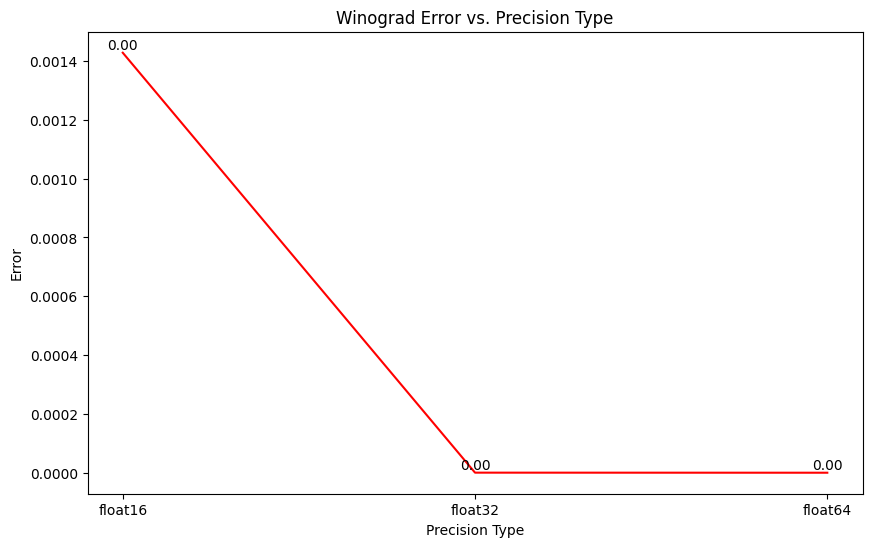

In [10]:
from src.conv2d import winograd
# TODO: plot the error v.s. precision curve
# precisions = [torch.float16, torch.bfloat16, torch.float32, torch.float64]
# precision_types = ['float16', 'bfloat16', 'float32', 'float64']

precisions = [torch.float16, torch.float32, torch.float64]
precision_types = ['float16', 'float32', 'float64']

error_lst, precisions = calculate_error(winograd, precisions)
plot_error_vs_precision(error_lst, precision_types, 'Winograd')

Precision: torch.float32, Loss: 1.5833983297852683e-06
Precision: torch.float64, Loss: 5.489466031704378e-08


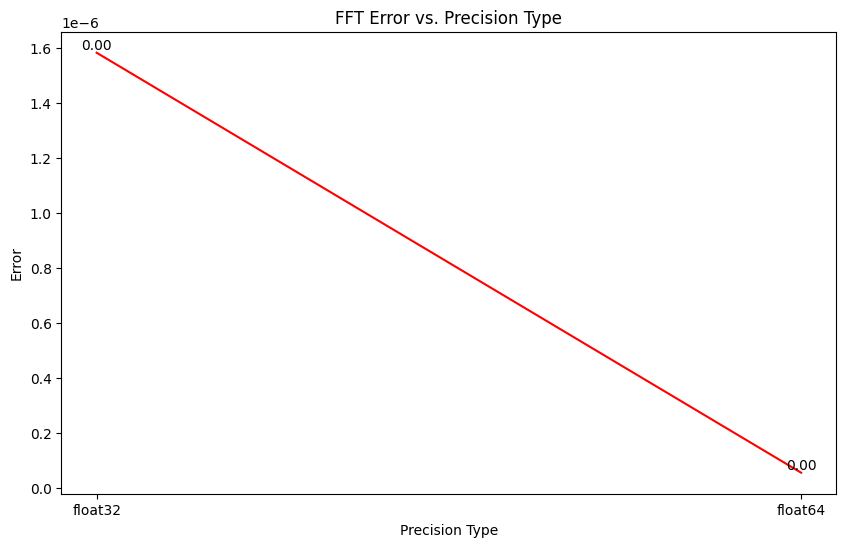

In [11]:
from src.conv2d import fft
# TODO: plot the error v.s. precision curve
precisions = [torch.float32, torch.float64]
precision_types = ['float32', 'float64']
# precisions = [torch.float16, torch.float32, torch.float64]
# precision_types = ['float16', 'float32', 'float64']

error_lst, precisions = calculate_error(fft, precisions)
plot_error_vs_precision(error_lst, precision_types, 'FFT')

# 3. Matrix-matrix Multiply

In the following cell(s), please plot the reconstruction error (in the y-axis)
with the different numerical precisions (in the x-axis) for `log` (i.e.
logorithmic matrix-matrix multiplication).

Precision: torch.float32, Loss: 5.360247996577527e-07
Precision: torch.float64, Loss: 9.382990532550567e-16


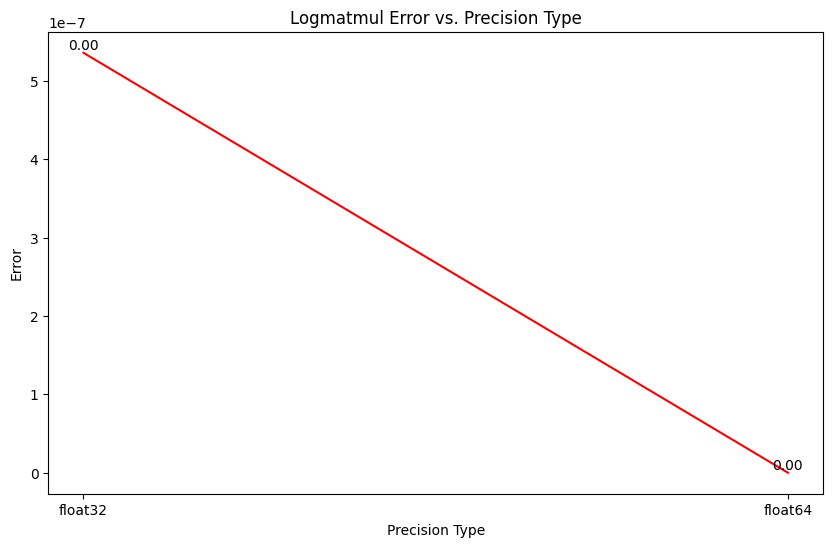

In [12]:
from src.matmul import logmatmul
from src.matmul import matmul
# TODO: plot the error v.s. precision curve
precisions = [torch.float32, torch.float64]
precision_types = ['float32', 'float64']
error_lst = []
M = 32
N = 32
K = 32
for precision in precisions:
  A = torch.randn(M, N, dtype=precision)
  B = torch.randn(N, K, dtype=precision)
  ans = matmul(A, B, method='torch')

  loss_lst = []
  for _ in range(10):
    out = logmatmul(A, B)
    loss_lst.append(F.l1_loss(ans, out).item())
  loss_avg = np.mean(loss_lst)
  error_lst.append(loss_avg)
  print(f"Precision: {precision}, Loss: {loss_avg}")

plot_error_vs_precision(error_lst, precision_types, 'Logmatmul')

Precision: torch.float16, Loss: 6.4921875
Precision: torch.float32, Loss: 6.310973167419434
Precision: torch.float64, Loss: 6.1476328504591695


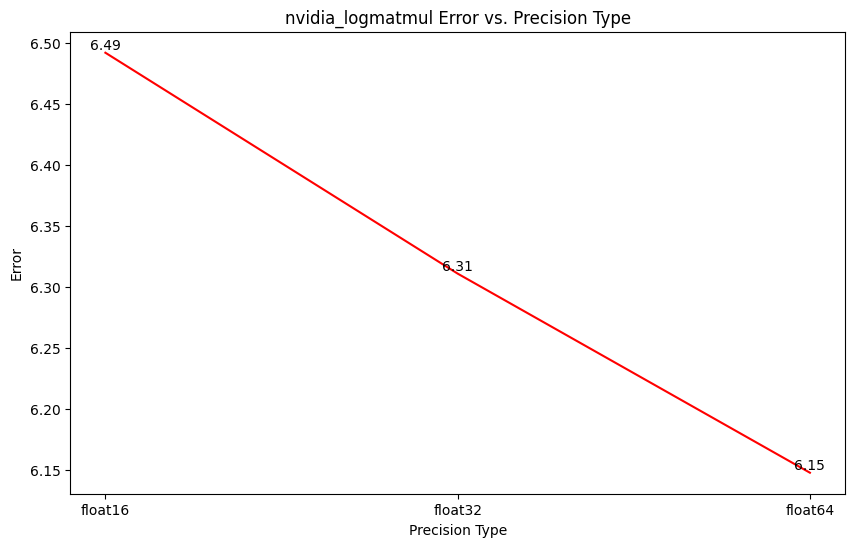

In [15]:
#Extra credit: Nvidia matmul
from src.matmul import nvidia_logmatmul

precisions = [torch.float16, torch.float32, torch.float64]
precision_types = ['float16', 'float32', 'float64']

error_lst = []
M = 32
N = 32
K = 32
for precision in precisions:
  A = torch.randn(M, N, dtype=precision)
  B = torch.randn(N, K, dtype=precision)
  ans = matmul(A, B, method='torch')

  loss_lst = []
  for _ in range(10):
    out = nvidia_logmatmul(A, B)
    loss_lst.append(F.l1_loss(ans, out).item())
  loss_avg = np.mean(loss_lst)
  error_lst.append(loss_avg)
  print(f"Precision: {precision}, Loss: {loss_avg}")

plot_error_vs_precision(error_lst, precision_types, 'nvidia_logmatmul')